In [13]:
from motion_utils import *
from matplotlib import pyplot as plt

In [52]:
sys=particle_system((1000,1000))
n=50
sys.insert_particles(n,lambda x,y : brownian_update(x,y,1,[0,0]),lambda x,y : 1)

dt=500
beg_pos=sys.positions()
beg_int=sys.intensities()

sys.evolve(dt)

end_pos=sys.positions()
end_int=sys.intensities()

In [53]:
a=np.array(beg_int).reshape((n,1))
b=np.array(end_int).reshape((n,1))#try to make the shapes match with all of the linear algebra behind this

def L2_cost(source,sink):
    C=np.empty((len(source),len(sink)))
    for i,pos1 in enumerate(source):
        for j, pos2 in enumerate(sink):
            C[i,j]=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
    return C

In [54]:
C = L2_cost(beg_pos,end_pos)
epsilon=0.1

In [10]:
#all of the cell taken from https://nbviewer.jupyter.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_6_entropic_adv.ipynb
#look there for explanation
def mina_u(H,epsilon): return -epsilon*np.log( np.sum(a * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon): return -epsilon*np.log( np.sum(b * np.exp(-H/epsilon),1) )


def mina(H,epsilon): return mina_u(H-np.min(H,0),epsilon) + np.min(H,0);
def minb(H,epsilon): return minb_u(H-np.min(H,1)[:,None],epsilon) + np.min(H,1);

def Sinkhorn(C,epsilon,f,niter = 500):    
    Err = np.zeros(niter)
    for it in range(niter):
        g = mina(C-f[:,None],epsilon)
        f = minb(C-g[None,:],epsilon)
        # generate the coupling
        P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
        # check conservation of mass
        Err[it] = np.linalg.norm(np.sum(P,0)-b,1)
    return (P,Err)

In [55]:
P,Err=Sinkhorn(C,epsilon,np.zeros(n),3000)

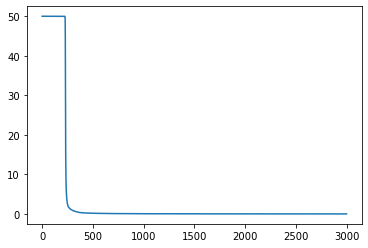

In [56]:
plt.plot(Err);

In [57]:
P

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.99833333e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.50772584e-53, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 8.97422676e-52]])

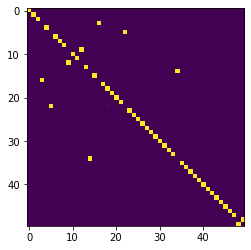

In [58]:
plt.imshow(P,interpolation='nearest')

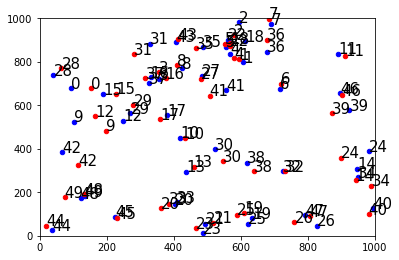

In [59]:
beg_x,beg_y= zip(*beg_pos)
end_x,end_y= zip(*end_pos)

fig,ax=plt.subplots()

ax.set_xlim([0,sys.grid[0]])
ax.set_ylim([0,sys.grid[1]])
ax.scatter(beg_x,beg_y,color='blue',s=20)
ax.scatter(end_x,end_y,color='red',s=20)
for i,pos in enumerate(beg_pos):
    ax.annotate(i,(pos[0],pos[1]),size=15)
for i,pos in enumerate(end_pos):
    ax.annotate(i,(pos[0],pos[1]),size=15)

Seems to work about as well as the non-regularized version

There is also a regularization that should return more sparse solutions. That combined with looking at intensities could be better for overlapping particles

https://arxiv.org/pdf/1903.01112.pdf describes efficient algorithms for computing it. For now let's use a generic solver and if it proves useful, then one can worry about speed

In [60]:
import cvxpy as cp

In [61]:
P=cp.Variable((n,n))
u = np.ones((n,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

In [77]:
gamma = 10
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) + gamma/2 * cp.sum(cp.square(P)))
prob = cp.Problem(objective, U)
result = prob.solve()

In [78]:
P.value

array([[ 1.00078084e+00, -1.53643127e-05, -1.59932128e-05, ...,
        -1.61283607e-05, -1.63124634e-05, -1.58347028e-05],
       [-1.53643127e-05,  1.00079377e+00, -1.62627366e-05, ...,
        -1.63978846e-05, -1.65819873e-05, -1.61042267e-05],
       [-1.59932128e-05, -1.62627366e-05,  1.00082396e+00, ...,
        -1.70267847e-05, -1.72108874e-05, -1.67331268e-05],
       ...,
       [-1.61283607e-05, -1.63978846e-05, -1.70267847e-05, ...,
         1.00083045e+00, -1.73460353e-05, -1.68682747e-05],
       [-1.58347028e-05, -1.61042267e-05, -1.67331268e-05, ...,
        -1.68682747e-05, -1.70523774e-05,  1.00081635e+00],
       [-1.63124634e-05, -1.65819873e-05, -1.72108874e-05, ...,
        -1.73460353e-05,  1.00083929e+00, -1.70523774e-05]])

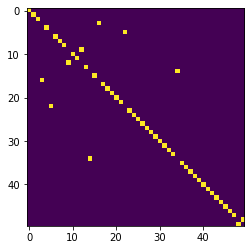

In [79]:
plt.imshow(P.value,interpolation='nearest')

Actually the solutions seem to be less sparse than those coming from Sinkhorn. I don't see how this form of regularization would make the solutions more sparse. Also, every single method tested so far is extremely fast for the number of particles that we are considering so maybe we can just use normal linear programming